# Compute Direction-Dependent Stopping Power
Given our previously-trained model, predict the effect of projectile direction on stopping power.

In [1]:
%matplotlib inline
import sys
from glob import glob
sys.path = glob('/projects/CSC249ADCD01/packages/*') + sys.path
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from stopping_power_ml.integrator import TrajectoryIntegrator
from stopping_power_ml.io import get_charge_density_interpolator
from math import gcd
from ase.io import cube
import pandas as pd
import pickle as pkl
import numpy as np
import gzip
import itertools
import os
from copy import deepcopy as copy

Set up Parsl

In [2]:
import parsl
from parsl import *
#from parsl_config import config
workers = IPyParallelExecutor()
dfk = DataFlowKernel(executors=[workers])
print("Parsl version : ", parsl.__version__)

Parsl version :  0.5.0


/home/wardlt/miniconda3/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@js-157-17.jetstream-cloud.org')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


## Load in Components for Model
Get the data, featurizers, and model

In [3]:
channel_data = pd.read_pickle(os.path.join('data', 'channel_data.pkl.gz'))

In [4]:
featurizers = pkl.load(open(os.path.join('..', 'featurizers.pkl'), 'rb'))[:-1]

In [5]:
model = pkl.load(open('best_model.pkl', 'rb'))

In [6]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

In [7]:
X_cols = sum([f.feature_labels() for f in featurizers], [])

Load charge density. Useful for plots

In [8]:
density, cell = get_charge_density_interpolator(os.path.join('..', 'datasets', '256_Al', 'Al_semi_core_gs.cube'))

Load in the weighting tool

In [9]:
def gaussian_weight(x, strength=1):
    """Weight by the distance from the mean using a Guassian
    
    w = np.exp(-1*(x-|x|)^2*strength)"""
    
    return np.exp(-strength * np.power(np.subtract(x, np.mean(x)), 2))

In [10]:
best_strength = pkl.load(open('best_weight.pkl', 'rb'))

## Evaluate the Model on a 'Channeling Trajectory'
One of our datasets is of the projectile moving along a 'channel' within the Al lattice. This trajectory is where the distance where the projectile travels least near any of the Al atoms, which means it should have the lowest stopping power

In [11]:
print('Test set size: %d entries'%len(channel_data))

Test set size: 2000 entries


### Plot the Force Predictions
Compare the predicted force as a function of displacement

In [12]:
lat_spacing = start_frame.cell[0,0] / 4

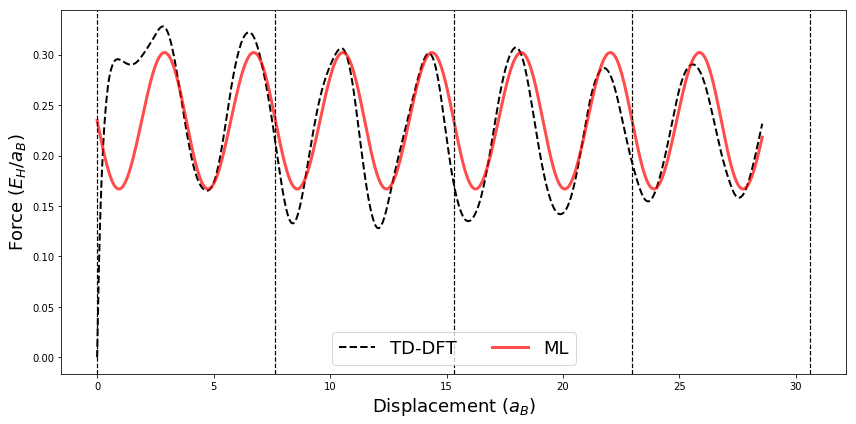

In [13]:
fig, ax = plt.subplots()

# Plot the true result
ax.plot(channel_data['displacement'], channel_data['force'], 'k--', label='TD-DFT', lw=2)

# Plot the ML predictions
fmean = model.predict(channel_data[X_cols])
channel_data['ml_force'] = fmean
# Note: The is a PR for sklearn to include ability to predict standard deviations for this model. 
#   If you'd like, we can install that development version
#ax.fill_between(channel_data['displacement'], fmean + fstd, fmean - fstd, color='r', alpha=0.5)
ax.plot(channel_data['displacement'], fmean, 'r-', alpha=0.7, label='ML', lw=3)

# Plot the sample range
ax.set_ylim(ax.get_ylim())

for i in range(5):
    ax.plot([lat_spacing * i, ] * 2, ax.get_ylim(), 'k--', lw=1.2)

ax.legend(ncol=2, fontsize=18)

ax.set_xlabel('Displacement ($a_B$)', fontsize=18)
ax.set_ylabel('Force ($E_H / a_B$)', fontsize=18)

fig.set_size_inches(12, 6)
fig.tight_layout()

This chart shows the force calculated via TD-DFT (black dashed line) and the predictions of the ML (red). The vertical black lines show points at which the cycle should repeat due to the periodicity of the crystal. Our ML results agree best with the simulation during the 3rd cycle, but overestimates the stopping force for the lower part of the curve.

### Add Channel to Training Set
Do we get better performance when we add the channel data to the training set?

Load the original training set

In [14]:
random_traj = pd.read_pickle(os.path.join('data', 'random_data.pkl.gz'))

In [15]:
training_set = pd.concat([random_traj, 
                          channel_data.query('displacement >= %f and displacement <= %f'%(lat_spacing, lat_spacing * 3))])\
                .query('initial == False')

In [16]:
training_set['directory'].value_counts()

datasets\256_Al\Dv1.0      9379
datasets\Al_256_channel    1072
Name: directory, dtype: int64

Train a new model

In [17]:
new_model = copy(model)

In [18]:
new_model.fit(training_set[X_cols], training_set['force'], model__sample_weight=gaussian_weight(training_set['force'], best_strength))

/home/wardlt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=4.838e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/home/wardlt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=4.838e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/home/wardlt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=4.838e-02, with an active set of 5 regressors, and the smallest cholesky pivot element 

GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('lasso_rfe', SelectFromModel(estimator=LassoLars(alpha=1e-10, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=False, fit_path=True, max_iter=22, normalize=True,
     positive=False, precompute='aut...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso_rfe__estimator__max_iter': range(5, 30), 'model__alpha': array([1.00000e-05, 1.29155e-04, 1.66810e-03, 2.15443e-02, 2.78256e-01,
       3.59381e+00, 4.64159e+01, 5.99484e+02, 7.74264e+03, 1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
new_model.best_params_

{'lasso_rfe__estimator__max_iter': 18, 'model__alpha': 1e-05}

Evaluate the channel data

In [20]:
channel_data['ml_force-new'] = new_model.predict(channel_data[X_cols])

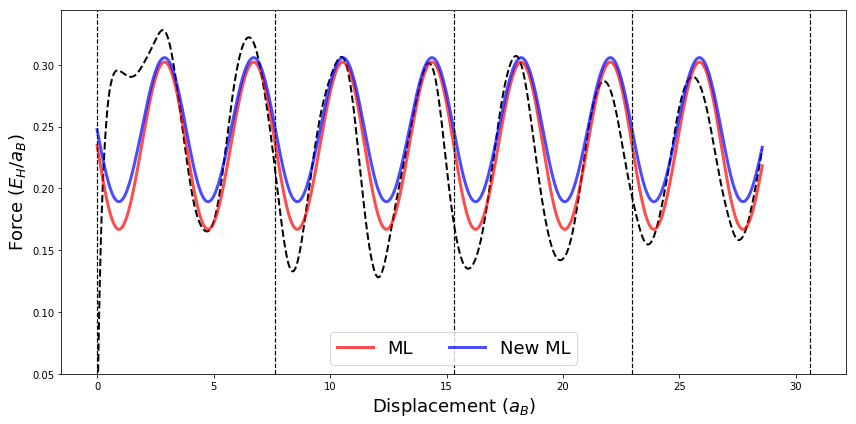

In [21]:
fig, ax = plt.subplots()

# Plot the true result
ax.plot(channel_data['displacement'], channel_data['force'].tolist(), 'k--', label=None, lw=2)

# Plot the ML predictions
#ax.fill_between(channel_data['displacement'], fmean + fstd, fmean - fstd, color='r', alpha=0.5)
ax.plot(channel_data['displacement'], channel_data['ml_force'], 'r-', alpha=0.7, label='ML', lw=3)
ax.plot(channel_data['displacement'], channel_data['ml_force-new'], 'b-', alpha=0.7, label='New ML', lw=3)

# Plot the sample range
ax.set_ylim(0.05, max(ax.get_ylim()))

for i in range(5):
    ax.plot([lat_spacing * i, ] * 2, ax.get_ylim(), 'k--', lw=1.2)

ax.legend(ncol=2, fontsize=18)

ax.set_xlabel('Displacement ($a_B$)', fontsize=18)
ax.set_ylabel('Force ($E_H / a_B$)', fontsize=18)

fig.set_size_inches(12, 6)
fig.tight_layout()

Adding in this training data has slight benefit to the model. It does not overestimate the stopping force on the top of the curve as significantly

### Compare the Stopping Powers
Compare the stopping power computed with TD-DFT for this channel, that for the random trajectory

Compute the stopping powers

In [22]:
channel_query = 'displacement >= %f and displacement <= %f'%(lat_spacing, 3 * lat_spacing)
ml_stopping = channel_data.query(channel_query)['ml_force'].mean()
ml_stopping_new = channel_data.query(channel_query)['ml_force-new'].mean()
channel_stopping = channel_data.query(channel_query)['force'].mean()
random_stopping = random_traj['force'].mean()

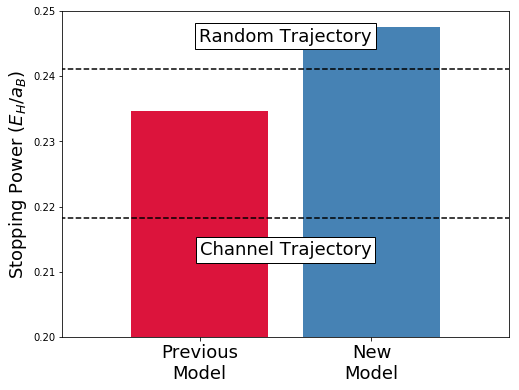

In [23]:
fig, ax = plt.subplots()

ax.bar([1,2], [ml_stopping, ml_stopping_new], color=['crimson','steelblue'])

ax.plot([0,4], [random_stopping,]*2, 'k--')
ax.text(1.5,random_stopping + 0.005, 'Random Trajectory', bbox={'facecolor':'w'}, ha='center', va='center',
       fontsize=18, color='k')
ax.plot([0,4], [channel_stopping,]*2, 'k--')
ax.text(1.5, channel_stopping - 0.005, 'Channel Trajectory', bbox={'facecolor':'w'}, ha='center', va='center',
       fontsize=18, color='k')

ax.set_xlim(0.2, 2.8)
ax.set_ylim(0.2, 0.25)

ax.set_xticks([1,2])
ax.set_xticklabels(['Previous\nModel', 'New\nModel'], fontsize=18)
ax.set_ylabel('Stopping Power ($E_H / a_B$)', fontsize=18)

fig.set_size_inches(8, 6)

## Compute Direction Dependent Stopping Power
With a projectile starting at the same position as the above trajectory, compute the stopping power if the projectile moves in different directions

### Make Integration Tool
The stopping power a certain trajectory is the average stopping force. In previous steps, we determined this average from many evenly-spaced timesteps. Determining the average stopping power via this method is simple to implement, but has significant disadvantages. If the force is smoothly varying, we may unwittingly sample more points than necessary to determine the average. If the function has large spikes [it does when he projectile passess near a nucleus], many samples are required to determine the average accurately. We will solve both problems by determining the average using aaptive numericla integration techniques.

Specifically, we plan to use adaptive Guassian quadrature. Adaptive quadrature determines the value of an integral by sampling a samll number of specially-chosen points that, when summed with appropriate weights, yield exact integrals of polynomial functions. For example, you can determine the exact integral of a linear function over the range $[a,b]$  by computing: $(b-a)f(\frac{a+b}{2})$. Adaptive quadrature works by iteratively increasing the number of sampling points until the change in the value of the integral is smaller than a desired threshold. Additionally, the particular implementation of this method we use further accelerates integration by intelligently splitting the integration region into separate subregions. The algorithm can then sample quickly-varying regions of th efunction more densely than slowly-varying ones. Overall, adaptive quadrature provides a simple scheme for fast and reliable estimate of stopping powers

In [24]:
traj_computer = TrajectoryIntegrator(atoms=start_frame, model=new_model, featurizers=featurizers)

Compute the stopping power using Quadrature

In [25]:
%%time
results = traj_computer.compute_stopping_power([0.2,0.2,0.03], [1, 1, 0], 1.0, full_output=1, hit_threshold=2.5)

CPU times: user 1min 15s, sys: 40 ms, total: 1min 15s
Wall time: 1min 15s


In [26]:
print('Stopping power by quadrature:', results[0])

Stopping power by quadrature: 0.036907389776537784


In [27]:
print('Number of iterations:', results[2]['neval'])

Number of iterations: 987


Compute the stopping power using standard integration

In [28]:
%%time
f = traj_computer._create_force_calculator([0.2,0.2,0.03], [1, 1, 0], 1.0)

X = np.linspace(0, 1, 101)
force = [f(x) for x in X]

CPU times: user 8.38 s, sys: 12 ms, total: 8.4 s
Wall time: 8.4 s


In [29]:
print('Stopping power by spacing:', np.mean(force))

Stopping power by spacing: 0.03605449650589361


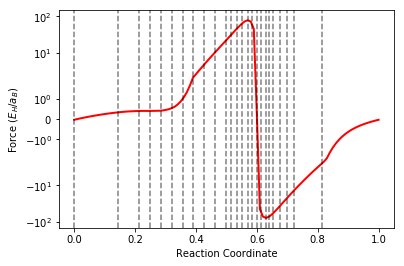

In [30]:
fig, ax = plt.subplots()

ax.plot(X, force, 'r', lw=2)

ax.set_xlabel('Reaction Coordinate')
ax.set_ylabel('Force ($E_H / a_B$)')

ax.set_yscale('symlog')
ax.set_ylim(ax.get_ylim())

mean = np.mean(force)
n_intervals = results[2]['last']
for a,b in zip(results[2]['alist'][:n_intervals],
              results[2]['blist'][:n_intervals]):
    ax.plot([a,a], ax.get_ylim(), 'k--', alpha=0.5)

Each of the vertical lines corresponds to a specific subinterval in the integration scheme. Note that they are packed more closely near the fast variations in the force, and less over smoothly-varying regions. 

In [31]:
pkl.dump(traj_computer, open('traj_computer.pkl', 'wb'))

### Stopping Power Moving out of Channel
This simulation models what happens if we gradually move the particle out of the [1 0 0] channel. The stopping power should gradually increase, as the particle is passing closer to the atom cores.

In [32]:
@App('python', dfk)
def get_stopping_power(starting_point, traj_computer):
    return traj_computer.compute_stopping_power(starting_point, [1, 0, 0], 1.0, abserr=0.0001, full_output=1)

Compute stopping power using adaptive integration

In [33]:
disps = np.linspace(0.7, 1.05, 22)

In [34]:
stopping_power_results = [get_stopping_power([0, 0.75, d], traj_computer) for d in disps]

In [35]:
%%time
stopping_power_results = [s.result() for s in tqdm(stopping_power_results)]


CPU times: user 132 ms, sys: 12 ms, total: 144 ms
Wall time: 12.1 s


Plot the stopping power value and number of steps

In [36]:
stopping_power = [s[0] for s in stopping_power_results]
stopping_power_err = [s[1] for s in stopping_power_results]

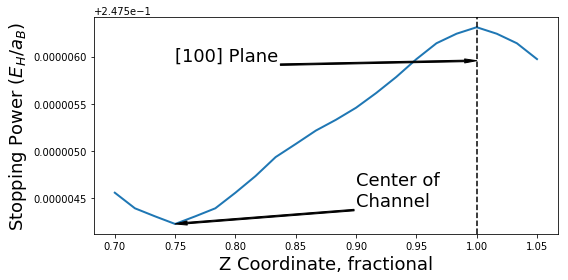

In [37]:
fig, ax = plt.subplots()

ax.plot(disps, stopping_power, lw=2)

ylim = ax.get_ylim()

ax.annotate('Center of\nChannel', xytext=(0.9, ylim[0] + 0.2 * (ylim[1] - ylim[0])),
            xy=(0.75, min(stopping_power)), va='center',
            fontsize=18, arrowprops={'color':'k', 'width':1.5, 'headwidth':4})

ax.set_ylim(ylim)

ax.plot([1,1], ax.get_ylim(), 'k--')
ax.annotate('[100] Plane',
            xytext=(0.75, ylim[0] + 0.8 * (ylim[1] - ylim[0])),
            xy=(1, ylim[0] + 0.8 * (ylim[1] - ylim[0])),
            fontsize=18, arrowprops={'color':'k', 'width':1.5, 'headwidth':4})

ax.set_xlabel('Z Coordinate, fractional', fontsize=18)
ax.set_ylabel('Stopping Power ($E_H / a_B$)', fontsize=18)

fig.set_size_inches(8, 4)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'moving-out-of-channel.png'), dpi=320)

Print the number of evaluations

In [38]:
neval = [x[2]['neval'] for x in stopping_power_results]

In [39]:
print('Average number of evaluations:', np.mean(neval))
print('Minimum number of evaluations:', np.min(neval))
print('Maximum number of evaluations:', np.max(neval))

Average number of evaluations: 51.54545454545455
Minimum number of evaluations: 21
Maximum number of evaluations: 105


This chart shows the stopping power as the trajectory moves from the center of the channel to the top of the channel. The stopping power is lowest in the center of the channel and highest at the top (which is along the [100] plane). 

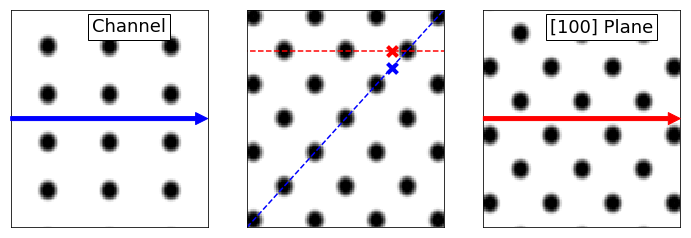

In [40]:
fig, ax = plt.subplots(1,3)
def make_trajectory_plot(ax, center, vec1, vec2, dist=0.4):
    # Compute the normal vectors
    vec1 = np.array(vec1) / np.linalg.norm(vec1)
    vec2 = np.array(vec2) / np.linalg.norm(vec2)
    
    # Make the grid
    spacings = np.linspace(-dist, dist, 128)
    xs, ys = np.meshgrid(spacings, spacings)
    points = np.array([i * vec1 + j * vec2 + center for i,j in zip(xs.flatten(), ys.flatten())])
    points = points % 1
    
    # Make the plots
    pct = ax.pcolor(xs, ys, np.log(density(points).reshape(xs.shape)), vmin=-3, vmax=1, cmap='Greys')
    
    ax.set_xticks([])
    ax.set_yticks([])
    return pct

make_trajectory_plot(ax[0], [0,0.75/4,0.75/4], [1,0,0], [0,1,1])
ax[0].annotate('', xy=(1,0.5), xytext=(0,0.5), xycoords='axes fraction',
               textcoords='axes fraction', arrowprops=dict(color='b'))

make_trajectory_plot(ax[1], [0,0,0], [1,0,0], [0,1,0])
ax[1].set_xlim(ax[1].get_xlim())
ax[1].set_ylim(ax[1].get_ylim())
ax[1].plot([-1,1],[-1,1],'b--')
ax[1].scatter([0.75/4,], [0.75/4,], color='b', s=100, marker='x', lw=4)
ax[1].plot([-1,1],[0.25,0.25],'r--')
ax[1].scatter([0.75/4,], [1./4,], color='r', s=100, marker='x', lw=4)

make_trajectory_plot(ax[2], [0,0.75/4,1./4], [1,0,0], [0,1,0])
ax[2].annotate('', xy=(1,0.5), xytext=(0,0.5), xycoords='axes fraction',
               textcoords='axes fraction', arrowprops=dict(color='r'))


ax[0].text(0.6, 0.9, 'Channel', transform=ax[0].transAxes, ha='center',
           bbox={'facecolor':'w', 'edgecolor':'k'}, fontsize=18)
ax[2].text(0.6, 0.9, '[100] Plane', transform=ax[2].transAxes, ha='center',
           bbox={'facecolor':'w', 'edgecolor':'k'}, fontsize=18)

fig.set_size_inches(12, 4)

These charts are all plots of the electron density of Aluminum. The center chart shows the locations of the channel trajectory (blue) and the out of channel (red). The channel trajectory passes down a direction that is optimally far from other atoms, as shown in the figure on the right that shows the slice of the 3d space where the projectile passes closest to atoms. Note that the channel trajectory projectile stays consistently farther from atoms than the channel trajectory (right).

### Stopping Power, Rotating In Plane
Now, we keep the same starting position but rotate the direction of travel. Specifically, we choose the [100] and [011] directions which should sample a wide variety of behavior

In [41]:
def generate_directions(max_length=4, vector1=[1,0,0], vector2=[0,1,1]):
    """Generate lattice vectors directions to evaluate. Rotating in the xy-plane
    
    :param max_length: int, maximum length of the lattice vector
    :return: 
        -[tuple of ints], lattice vectors to scan, sorted by angle
        -[float], angles with respect to [100]"""
    
    # Make the list of directions
    dirs = set()
    def add_pair(i, j):
        d = gcd(i,j)
        dirs.add(tuple([int(a*i/d+b*j/d) for a,b in zip(vector1, vector2)]))
    for i in range(0, max_length+1): # Iterate up from zero to start with shorter paths ([100] vs [500])
        for j in range(0, max_length-i+1):
            if i == 0 and j == 0: continue
            for x,y in itertools.product([i,-i],[j,-j]):
                add_pair(x,y)
    
    # Compute the angles
    angles = [np.arctan2(np.dot(vector2,d)/np.linalg.norm(vector2),
                         np.dot(vector1,d)/np.linalg.norm(vector1)) for d in dirs]
    return zip(*sorted(zip(dirs,angles), key=lambda x: x[1]))
dirs, angles = generate_directions(6)

In [42]:
traj_computer.prim_strc

Structure Summary
Lattice
    abc : 5.4135741614251485 5.4135741614251485 5.4135741614251485
 angles : 60.00000000000001 60.00000000000001 60.00000000000001
 volume : 112.18564108075496
      A : 0.0 -3.827975 -3.827975
      B : 3.827975 0.0 -3.827975
      C : 3.827975 -3.827975 0.0
PeriodicSite: Al (3.8280, -3.8280, -3.8280) [0.5000, 0.5000, 0.5000]

In [43]:
@App('python', dfk)
def get_stopping_power(lattice_vector, traj_computer):
    return traj_computer.compute_stopping_power([0,0.75,0.85], lattice_vector, 1.0, abserr=0.0001,
                                                hit_threshold=2.5, full_output=1)

In [44]:
stopping_power_results = []
for d in tqdm(dirs, desc='Submitting'):
    stopping_power_results.append(get_stopping_power(d, traj_computer))

In [45]:
stopping_power_results = [s.result() for s in tqdm(stopping_power_results, desc='Waiting')]

In [46]:
pkl.dump(stopping_power_results, open('stopping_power_results.pkl', 'wb'))

In [47]:
stopping_power = [s[0] for s in stopping_power_results]

In [48]:
stopping_power_results[1][-1]

{'neval': 777,
 'last': 22,
 'iord': array([          6,           9,           8,          12,          19,
                  3,          15,          16,          18,          22,
                 10,          17,           4,          21,          14,
                  1,           7,          13,           5,           2,
                 11,          20, -1844573693,  1075748786,  -306873695,
         1076295621,  -306873695,  1076295621,           0,           0,
         -306873695,  1076295621, -1844573693,  1075748786, -1833314694,
         1074700210, -1844573693,  1075748786,  -306873695,  1076295621,
        -1833314694,  1074700210, -1844573693,  1075748786, -1844573693,
         1075748786,           0,           0,  -306873695,  1076295621,
        -1833314694,  1074700210, -1844573693,  1075748786,  -306873695,
         1076295621,           0,           0,  -306873695,  1076295621,
        -1844573693,  1075748786, -1833314694,  1074700210,  -306873695,
         107629

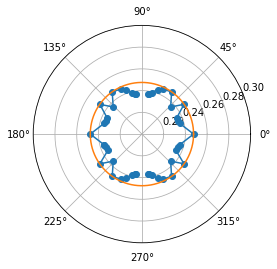

In [49]:
ax = plt.subplot(111, projection='polar')
fig = plt.gcf()

ax.plot(angles + angles[:1], stopping_power + stopping_power[:1], marker='o')

# Plot the 'channel value'
ax.plot(np.linspace(0, 2*np.pi, 100), [ml_stopping_new,]*100)
ax.set_rmax(0.3)
ax.set_rmin(0.2)#min(stopping_power) * 0.99)

fig.set_size_inches(4, 4)
fig.savefig(os.path.join('figures', 'rotation-in-110-plane.png'), dpi=320)

The above plot shows the stopping power as a function of angle where 0 is the channel direction [100] and 90 is a direction that nearly interects atoms [011]. As expected, there is significant variation of the stopping power depending on direction. We find the near lowest stopping powers at 0 degrees, which aligns in the channel direction where the projectile it does not incercept any atoms, as shown in the red line below. The highest stopping powers are along the 90 and 270 degree angles, which nearly intercept many atoms along the path (cyan). Interestingly, we find exceptionally low stopping powers along directions besides the [100] channel (purple). If true, this is a neat finding. If not, it indicates a region where we could add data to our model and to improve its accuracy.

In [50]:
direction_stopping = pd.DataFrame({'angle':angles, 'S': stopping_power, 'dir': dirs})

In [51]:
direction_stopping.to_pickle('direction_stopping.pkl')

In [52]:
min_angle = direction_stopping.sort_values(['S','angle'], ascending=True).iloc[0]
max_angle = direction_stopping.sort_values(['S','angle'], ascending=False).iloc[0]

In [53]:
min_angle, max_angle

(S           0.172981
 angle        -1.5708
 dir      (0, -1, -1)
 Name: 11, dtype: object, S          0.247505
 angle       3.14159
 dir      (-1, 0, 0)
 Name: 47, dtype: object)

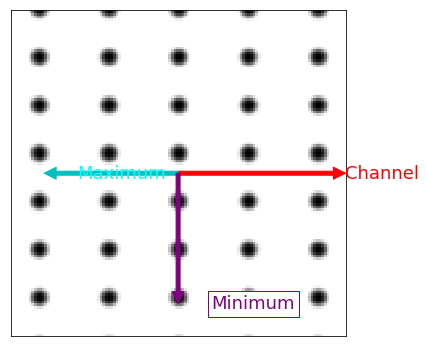

In [54]:
fig, ax = plt.subplots()

min_angle_dir = 0.5 + 0.4 * np.array((np.cos(min_angle['angle']), np.sin(min_angle['angle'])))
max_angle_dir = 0.5 + 0.4 * np.array((np.cos(max_angle['angle']), np.sin(max_angle['angle'])))

make_trajectory_plot(ax, [0,0.75/4,0.85/4], [1,0,0], [0,1,1], 0.6)
ax.annotate('', xy=(1,0.5), xytext=(0.5,0.5), xycoords='axes fraction',
            textcoords='axes fraction', arrowprops=dict(color='r'))
ax.text(1, 0.5, 'Channel', color='r', transform=ax.transAxes,
       fontsize=18, va='center')
ax.annotate('', xy=max_angle_dir, xytext=(0.5,0.5), xycoords='axes fraction',
            textcoords='axes fraction', arrowprops=dict(color='c'))
ax.text(max_angle_dir[0] + 0.1, max_angle_dir[1], 'Maximum', color='cyan', transform=ax.transAxes,
       fontsize=18, va='center', ha='left')
ax.annotate('', xy=min_angle_dir, xytext=(0.5,0.5), xycoords='axes fraction',
            textcoords='axes fraction', arrowprops=dict(color='purple'))
ax.text(min_angle_dir[0] + 0.1, min_angle_dir[1], 'Minimum', color='purple', transform=ax.transAxes,
       fontsize=18, va='center', ha='left', bbox={'facecolor':'w', 'edgecolor':'purple'})

fig.set_size_inches(6, 6)

In [55]:
dfk.cleanup()